<a href="https://colab.research.google.com/github/ahs95/sentiment-analysis-cwcbd23/blob/main/Copy_of_sentiment_analysis_bdcric23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install iterative-stratification
!pip install --upgrade datasets
!pip install bitsandbytes
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 16.8 MB/s eta 0:00:00
 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [7]:
import torch
import bitsandbytes as bnb
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_scheduler, AutoTokenizer, BertForSequenceClassification
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [8]:
data = pd.read_excel('/content/drive/MyDrive/Data_Cric23_BD.xlsx')
data

,source,text,sentiment,sarcasm
0,Khelajog,বাংলাদেশ ৩৫ রানে জয়ী,positive,non-sarcastic
1,Khelajog,"যা হবার হয়েছে, ইনশাআল্লাহ আমার প্রিয় বাংলাদেশ ...",positive,non-sarcastic
2,Khelajog,ক্রিকেট মাস্টারমাইন্ড নবাব সাকিব,positive,non-sarcastic
3,Khelajog,গভেট মাহাদী এসে খেলাযোগে এখন একক খেলোয়াড়ের গুণ...,negative,non-sarcastic
4,Khelajog,"গাদ্দার কে নিয়ে এতো মাতামাতির কি আছে, খেলাযোগ",negative,non-sarcastic
...,...,...,...,...
5630,NaN,"আলহামদুলিল্লাহ আজ বাংলাদেশ জয় করেছে, পরাজিত হ...",positive,non-sarcastic
5631,NaN,"আমাদের একজন রিয়াদ ভাই ছিল, যাকে ভালবাসত পুরো ...",positive,non-sarcastic
5632,NaN,"ভদ্র মানুষের কথা ভিন্ন, নাফিজ ভাই এটাকে পারিবা...",positive,non-sarcastic
5633,NaN,আমি সত্যিই আনন্দিত যে বাংলাদেশ জিতেছে,positive,non-sarcastic


In [9]:
data.drop('source', axis=1, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5635 entries, 0 to 5634
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5635 non-null   object
 1   sentiment  5635 non-null   object
 2   sarcasm    5635 non-null   object
dtypes: object(3)
memory usage: 132.2+ KB


In [11]:
print(data.isnull().sum())

text         0
sentiment    0
sarcasm      0
dtype: int64


In [12]:
data.shape

(5635, 3)

In [13]:
data['sentiment'].value_counts()

,count
sentiment,
negative,4010
positive,1190
neutral,435


In [14]:
data['sarcasm'].value_counts()

,count
sarcasm,
non-sarcastic,4271
sarcastic,1364


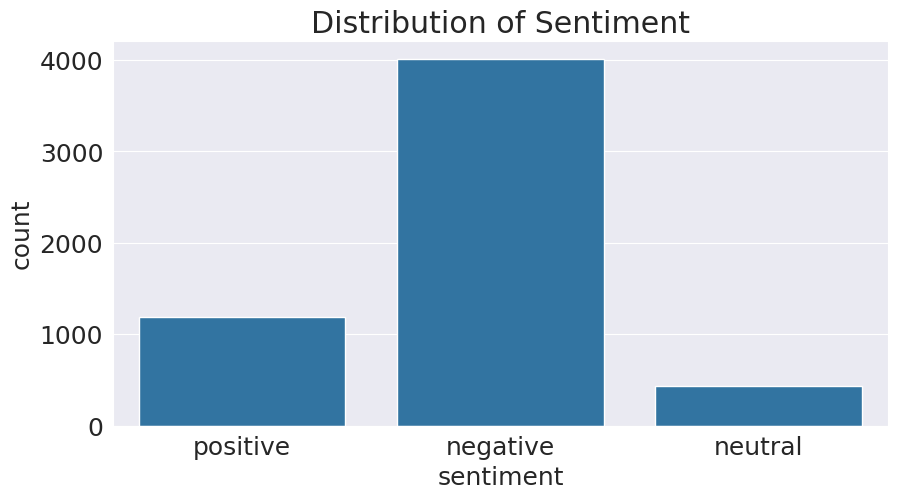

In [15]:
# Distribution of sentiment
plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment', data=data)
plt.title('Distribution of Sentiment')
plt.show()

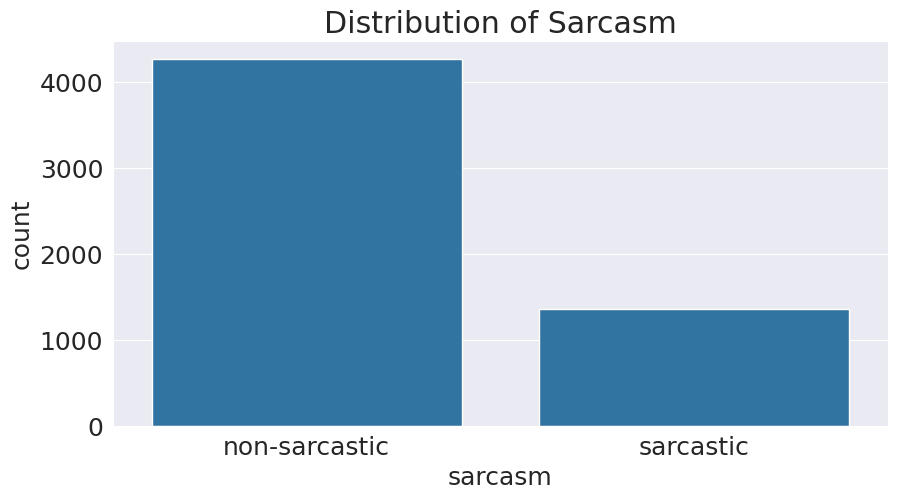

In [16]:
# Distribution of sarcasm
plt.figure(figsize=(10, 5))
sns.countplot(x='sarcasm', data=data)
plt.title('Distribution of Sarcasm')
plt.show()

In [17]:
from collections import Counter
Counter(" ".join(data["text"]).split()).most_common(200)

[('বাংলাদেশ', 1135),
 ('না', 1037),
 ('আর', 821),
 ('করে', 797),
 ('ক্রিকেট', 762),
 ('কে', 576),
 ('সাকিব', 567),
 ('বাংলাদেশের', 556),
 ('এই', 538),
 ('ভালো', 524),
 ('জন্য', 512),
 ('আমাদের', 500),
 ('হবে', 493),
 ('থেকে', 470),
 ('করতে', 444),
 ('কি', 426),
 ('পাপন', 420),
 ('করা', 404),
 ('ও', 395),
 ('এর', 389),
 ('যে', 372),
 ('সাথে', 367),
 ('আমরা', 328),
 ('ম্যাচ', 328),
 ('কিছু', 317),
 ('তো', 317),
 ('সব', 315),
 ('এবং', 309),
 ('দল', 300),
 ('কোন', 295),
 ('একটা', 287),
 ('বিশ্বকাপ', 286),
 ('দলের', 286),
 ('যদি', 277),
 ('তার', 275),
 ('না।', 271),
 ('আমি', 266),
 ('খেলা', 263),
 ('তামিম', 243),
 ('ভাই', 240),
 ('কোচ', 236),
 ('বিসিবি', 231),
 ('দেশের', 229),
 ('রান', 224),
 ('আছে', 223),
 ('মনে', 223),
 ('বাদ', 221),
 ('দিয়ে', 216),
 ('কথা', 214),
 ('কিন্তু', 209),
 ('অনেক', 209),
 ('তাহলে', 205),
 ('নাই', 204),
 ('সে', 200),
 ('তাদের', 200),
 ('এখন', 197),
 ('নান্নু', 194),
 ('নিয়ে', 190),
 ('তারা', 190),
 ('শেষ', 189),
 ('হোক', 188),
 ('হবে।', 187),
 ('এটা', 185),
 ('উচ

In [18]:
# Load custom stop words from a file
def load_custom_stop_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words = set(file.read().splitlines())
    return stop_words

In [19]:
# Define the path to your custom stop words file
stop_words_file_path = '/content/drive/MyDrive/custom_stop_words.txt'
custom_stop_words = load_custom_stop_words(stop_words_file_path)

In [20]:
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove custom stop words
    text = ' '.join([word for word in text.split() if word.lower() not in custom_stop_words])
    return text

In [21]:
# Assume the text column is named 'text'. Replace 'text' with the actual column name.
data['text'] = data['text'].astype(str).apply(clean_text)

In [22]:
data.head(10)

,text,sentiment,sarcasm
0,বাংলাদেশ ৩৫ রানে জয়ী,positive,non-sarcastic
1,যা হবার হয়েছে ইনশাআল্লাহ আমার প্রিয় বাংলাদেশ ক...,positive,non-sarcastic
2,ক্রিকেট মাস্টারমাইন্ড নবাব সাকিব,positive,non-sarcastic
3,গভেট মাহাদী এসে খেলাযোগে একক খেলোয়াড়ের গুণকীর্...,negative,non-sarcastic
4,গাদ্দার নিয়ে মাতামাতির আছে খেলাযোগ,negative,non-sarcastic
5,বাংলাদেশ নেটেই সেরা,negative,sarcastic
6,জুয়াড়ি আল হাসান,negative,sarcastic
7,জিতাটাই মূখ্য জিততেই হবে,neutral,non-sarcastic
8,সুজন ভাল কাজ করছে,positive,non-sarcastic
9,ওরা কোথায় কখন হাগতে যাই কখন বউয়ের কাছে শুতে যা...,negative,sarcastic


In [23]:
data.text.str.len().max()

3044

In [24]:
from collections import Counter
Counter(" ".join(data["text"]).split()).most_common(100)

[('না', 1214),
 ('বাংলাদেশ', 1171),
 ('করে', 823),
 ('ক্রিকেট', 764),
 ('সাকিব', 593),
 ('হবে', 570),
 ('বাংলাদেশের', 564),
 ('ভালো', 536),
 ('জন্য', 523),
 ('আমাদের', 501),
 ('থেকে', 477),
 ('পাপন', 453),
 ('করতে', 450),
 ('করা', 413),
 ('সাথে', 371),
 ('আমরা', 335),
 ('ম্যাচ', 333),
 ('কিছু', 318),
 ('সব', 318),
 ('দল', 305),
 ('কোন', 295),
 ('বিশ্বকাপ', 291),
 ('একটা', 288),
 ('দলের', 287),
 ('তার', 276),
 ('না।', 271),
 ('খেলা', 270),
 ('আমি', 270),
 ('আছে', 261),
 ('তামিম', 256),
 ('নাই', 249),
 ('কোচ', 243),
 ('বিসিবি', 239),
 ('দেশের', 230),
 ('রান', 228),
 ('বাদ', 224),
 ('নান্নু', 223),
 ('মনে', 223),
 ('দিয়ে', 217),
 ('হোক', 216),
 ('কথা', 216),
 ('উচিত', 210),
 ('তাহলে', 208),
 ('হয়', 204),
 ('পারে', 202),
 ('তাদের', 200),
 ('শেষ', 192),
 ('নিয়ে', 190),
 ('হবে।', 187),
 ('করার', 182),
 ('চাই', 181),
 ('আমার', 180),
 ('সাকিবের', 180),
 ('টিম', 175),
 ('লজ্জা', 175),
 ('আগে', 172),
 ('পদত্যাগ', 171),
 ('ব্যাটিং', 168),
 ('বলে', 158),
 ('হয়ে', 158),
 ('ছিল', 153),
 ('এদের', 153

In [25]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert_small")

def tokenize_function(text):
    return tokenizer(text, padding="max_length", max_length=512, truncation=True)

# Apply tokenization
tokenized_data = data['text'].apply(lambda x: tokenize_function(x))
tokenized_data = pd.DataFrame(tokenized_data.tolist())

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [26]:
# Combine tokenized data with labels
tokenized_data['sentiment'] = data[['sentiment']]
tokenized_data['sarcasm'] = data[['sarcasm']]

# One-hot encode sentiment and sarcasm columns for stratified k-fold
data = pd.get_dummies(data, columns=['sentiment', 'sarcasm'])

In [27]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        # Ensure each item is correctly extracted as a single entry, not a list of lists
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [28]:
class DualHeadModel(nn.Module):
    def __init__(self):
        super(DualHeadModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("csebuetnlp/banglabert_small", num_labels=3) # 3 sentiment classes
        self.dropout = nn.Dropout(0.3)
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, 3) # 3 sentiment classes
        self.sarcasm_classifier = nn.Linear(self.bert.config.hidden_size, 2)  # 2 sarcasm classes

    def forward(self, input_ids, attention_mask):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        sarcasm_logits = self.sarcasm_classifier(pooled_output)
        return sentiment_logits, sarcasm_logits

model = DualHeadModel()

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert_small and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.La

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [30]:
# Class distribution
class_counts = torch.tensor([4010, 1190, 435], dtype=torch.float)

# Calculate class weights
class_weights = sum(class_counts) / class_counts

# Convert to PyTorch tensor and move to device
class_weights = class_weights.to(device)

In [31]:
# Class distribution for sarcasm classes
sarcasm_class_counts = torch.tensor([4271, 1364], dtype=torch.float)

# Calculate class weights for sarcasm classes
sarcasm_class_weights = sum(sarcasm_class_counts) / sarcasm_class_counts

# Convert to PyTorch tensor and move to device
sarcasm_class_weights = sarcasm_class_weights.to(device)

In [32]:
import torch.nn.functional as F

def focal_loss(logits, labels, alpha=1, gamma=2, weight=None):
    ce_loss = F.cross_entropy(logits, labels, weight=weight, reduction='none')
    p_t = torch.exp(-ce_loss)
    focal_loss = alpha * (1 - p_t) ** gamma * ce_loss
    return focal_loss.mean()

In [33]:
def custom_loss_fn(sentiment_logits, sarcasm_logits, sentiment_labels, sarcasm_labels,
                   sentiment_weight=None, sarcasm_weight=None):
    sentiment_loss = focal_loss(sentiment_logits, sentiment_labels, weight=sentiment_weight)
    sarcasm_loss = focal_loss(sarcasm_logits, sarcasm_labels, weight=sarcasm_weight)
    return sentiment_loss + sarcasm_loss

In [34]:
kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Apply tokenization and store it as a dictionary
tokenized_data = tokenizer(data['text'].tolist(), padding="max_length", max_length=512, truncation=True, return_tensors="pt")

# Prepare the labels separately as a tensor
labels = data[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'sarcasm_sarcastic', 'sarcasm_non-sarcastic']].values
folds = kf.split(tokenized_data['input_ids'], labels)

accumulation_steps = 2  # Accumulate gradients over 2 batches

for fold, (train_index, val_index) in enumerate(folds):
    print(f"Training fold {fold + 1}")

    # Extract the train and validation sets
    train_encodings = {key: val[train_index] for key, val in tokenized_data.items()}
    val_encodings = {key: val[val_index] for key, val in tokenized_data.items()}

    train_labels = labels[train_index]
    val_labels = labels[val_index]

    # Calculate the distribution of sentiment classes in the training data
    sentiment_counts = np.sum(train_labels[:, :3], axis=0)
    sarcasm_counts = np.sum(train_labels[:, 3:], axis=0)

    print(f"Fold {fold + 1} Sentiment Class Distribution:")
    print(f"Negative: {sentiment_counts[2]}")
    print(f"Neutral: {sentiment_counts[1]}")
    print(f"Positive: {sentiment_counts[0]}")

    print(f"Fold {fold + 1} Sarcasm Class Distribution:")
    print(f"Sarcastic: {sarcasm_counts[0]}")
    print(f"Non-Sarcastic: {sarcasm_counts[1]}")
    print("\n" + "-"*50 + "\n")

    train_dataset = CustomDataset(train_encodings, train_labels)
    val_dataset = CustomDataset(val_encodings, val_labels)

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=2e-5, optim_bits=8)
    num_epochs = 5
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        optimizer.zero_grad()  # Reset gradients at the start of each epoch

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            sentiment_logits, sarcasm_logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            sentiment_labels = torch.argmax(batch["labels"][:, :3], dim=1)  # Sentiment
            sarcasm_labels = torch.argmax(batch["labels"][:, 3:], dim=1)  # Sarcasm
            loss = custom_loss_fn(sentiment_logits, sarcasm_logits, sentiment_labels, sarcasm_labels,
                              sentiment_weight=class_weights, sarcasm_weight=sarcasm_class_weights)


            # Accumulate gradients
            loss = loss / accumulation_steps
            loss.backward()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            total_train_loss += loss.item() * accumulation_steps

        avg_train_loss = total_train_loss / len(train_dataloader)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        all_sentiment_preds = []
        all_sentiment_labels = []
        all_sarcasm_preds = []
        all_sarcasm_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                sentiment_logits, sarcasm_logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                sentiment_labels = torch.argmax(batch["labels"][:, :3], dim=1)  # Sentiment
                sarcasm_labels = torch.argmax(batch["labels"][:, 3:], dim=1)    # Sarcasm
                loss = custom_loss_fn(sentiment_logits, sarcasm_logits, sentiment_labels, sarcasm_labels,
                              sentiment_weight=class_weights, sarcasm_weight=sarcasm_class_weights)


                total_val_loss += loss.item()

                # Store predictions and true labels for F1 score and confusion matrix
                all_sentiment_preds.extend(torch.argmax(sentiment_logits, dim=1).cpu().numpy())
                all_sentiment_labels.extend(sentiment_labels.cpu().numpy())
                all_sarcasm_preds.extend(torch.argmax(sarcasm_logits, dim=1).cpu().numpy())
                all_sarcasm_labels.extend(sarcasm_labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

Training fold 1
Fold 1 Sentiment Class Distribution:
Negative: 3208
Neutral: 348
Positive: 952
Fold 1 Sarcasm Class Distribution:
Sarcastic: 1091
Non-Sarcastic: 3417

--------------------------------------------------

Epoch 1/5 - Training Loss: 3.5042 - Validation Loss: 3.0918
Epoch 2/5 - Training Loss: 3.1126 - Validation Loss: 3.1117
Epoch 3/5 - Training Loss: 3.1002 - Validation Loss: 3.0626
Epoch 4/5 - Training Loss: 3.0605 - Validation Loss: 3.0208
Epoch 5/5 - Training Loss: 2.8742 - Validation Loss: 2.7551
Training fold 2
Fold 2 Sentiment Class Distribution:
Negative: 3208
Neutral: 348
Positive: 952
Fold 2 Sarcasm Class Distribution:
Sarcastic: 1091
Non-Sarcastic: 3417

--------------------------------------------------

Epoch 1/5 - Training Loss: 2.6132 - Validation Loss: 2.6545
Epoch 2/5 - Training Loss: 2.4560 - Validation Loss: 2.6194
Epoch 3/5 - Training Loss: 2.2886 - Validation Loss: 2.4257
Epoch 4/5 - Training Loss: 2.1545 - Validation Loss: 2.3091
Epoch 5/5 - Training L

In [35]:
# Calculate F1 scores
sentiment_f1 = f1_score(all_sentiment_labels, all_sentiment_preds, average="weighted")
sarcasm_f1 = f1_score(all_sarcasm_labels, all_sarcasm_preds, average="weighted")

print(f"Sentiment F1 Score: {sentiment_f1:.4f}")
print(f"Sarcasm F1 Score: {sarcasm_f1:.4f}")

Sentiment F1 Score: 0.8914
Sarcasm F1 Score: 0.8393


In [36]:
# Print classification reports
print("Sentiment Classification Report:")
print(classification_report(all_sentiment_labels, all_sentiment_preds, target_names=['positive', 'neutral', 'negative']))

print("Sarcasm Classification Report:")
print(classification_report(all_sarcasm_labels, all_sarcasm_preds, target_names=['sarcastic', 'non-sarcastic']))


Sentiment Classification Report:
              precision    recall  f1-score   support

    positive       0.97      0.59      0.73       238
     neutral       0.60      0.82      0.69        87
    negative       0.93      1.00      0.96       802

    accuracy                           0.90      1127
   macro avg       0.83      0.80      0.79      1127
weighted avg       0.91      0.90      0.89      1127

Sarcasm Classification Report:
               precision    recall  f1-score   support

    sarcastic       0.96      0.44      0.60       273
non-sarcastic       0.85      0.99      0.91       854

     accuracy                           0.86      1127
    macro avg       0.90      0.72      0.76      1127
 weighted avg       0.87      0.86      0.84      1127



In [37]:
# Confusion matrices
sentiment_cm = confusion_matrix(all_sentiment_labels, all_sentiment_preds)
sarcasm_cm = confusion_matrix(all_sarcasm_labels, all_sarcasm_preds)

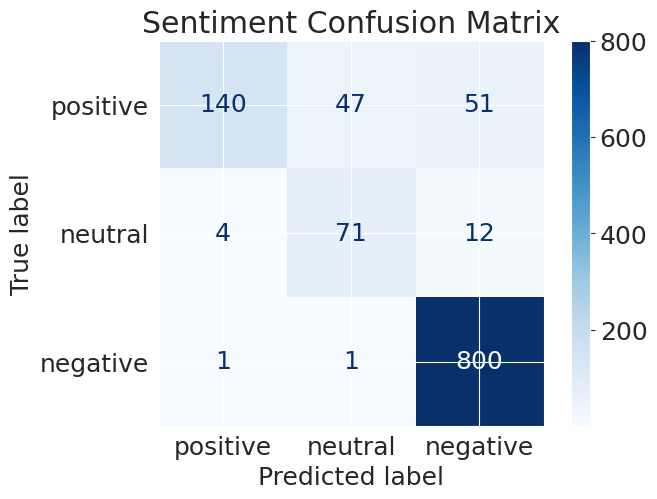

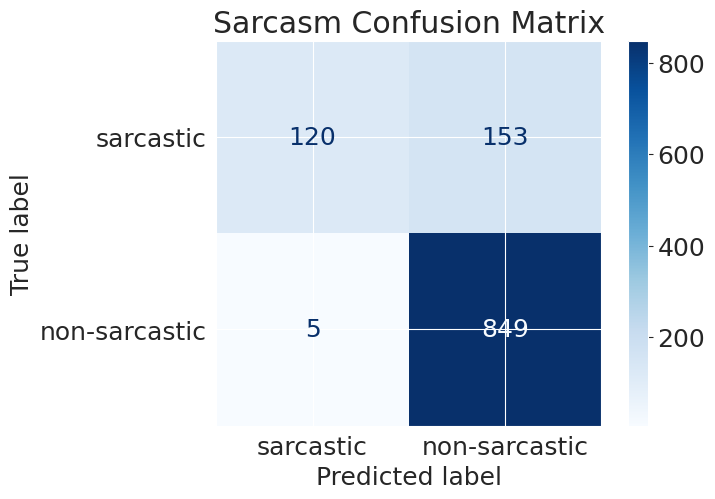

In [38]:
# Plot confusion matrices separately
# Sentiment Confusion Matrix
fig1, ax1 = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay(sentiment_cm, display_labels=['positive', 'neutral', 'negative']).plot(ax=ax1, cmap=plt.cm.Blues, values_format='d')
ax1.set_title('Sentiment Confusion Matrix')
plt.show()

# Sarcasm Confusion Matrix
fig2, ax2 = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay(sarcasm_cm, display_labels=['sarcastic', 'non-sarcastic']).plot(ax=ax2, cmap=plt.cm.Blues, values_format='d')
ax2.set_title('Sarcasm Confusion Matrix')
plt.show()

In [40]:
model_path = '/content/drive/MyDrive/model.pth'

# Save model state_dict
torch.save(model.state_dict(), model_path)
tokenizer.save_pretrained("/content/drive/MyDrive")

('/content/drive/MyDrive/tokenizer_config.json',
 '/content/drive/MyDrive/special_tokens_map.json',
 '/content/drive/MyDrive/vocab.txt',
 '/content/drive/MyDrive/added_tokens.json',
 '/content/drive/MyDrive/tokenizer.json')

In [55]:
import gradio as gr
import torch.nn.functional as F

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive")

# Reinitialize the model and load the saved weights
model = DualHeadModel()
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def classify_text(text):
    try:
        # Tokenize the input
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Make predictions
        with torch.no_grad():
            sentiment_logits, sarcasm_logits = model(inputs["input_ids"], inputs["attention_mask"])

        # Get sentiment prediction
        sentiment_preds = torch.argmax(sentiment_logits, dim=1).item()
        sarcasm_preds = torch.argmax(sarcasm_logits, dim=1).item()

        # Convert numeric prediction to labels
        sentiment_labels = {0: "Positive", 1: "Neutral", 2: "Negative"}
        sarcasm_labels = {0: "Sarcastic", 1: "Non-Sarcastic"}

        sentiment = sentiment_labels.get(sentiment_preds, "Unknown")
        sarcasm = sarcasm_labels.get(sarcasm_preds, "Unknown")

        return sentiment, sarcasm

    except Exception as e:
        # Catch and display any errors
        return f"Error: {str(e)}", "Error in Sarcasm Prediction"

import gradio as gr

# Create the Gradio interface
interface = gr.Interface(
    fn=classify_text,
    inputs="text",
    outputs=[
        gr.Textbox(label="Sentiment Prediction"),
        gr.Textbox(label="Sarcasm Prediction")
    ],
    title="Sentiment and Sarcasm Detection",
    description="This simple UI predicts the sentiment and sarcasm in Bangla social media comments related to the Bangladesh cricket team's performance."
)

# Launch the interface
interface.launch()

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert_small and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'en

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f5d19f2c7de026fe54.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
